Parameter counts: {'Layer 1': 5, 'Layer 2': 6, 'Layer 3': 0, 'Layer 4': 10, 'Layer 5': 0, 'Layer 6': 6}
Total number of parameters: 27
Epoch [10/100], Loss: 0.1124, Test Accuracy: 0.9561
Epoch [20/100], Loss: 0.0967, Test Accuracy: 0.9649
Epoch [30/100], Loss: 0.1031, Test Accuracy: 0.9561
Epoch [40/100], Loss: 0.1226, Test Accuracy: 0.9561
Epoch [50/100], Loss: 0.1248, Test Accuracy: 0.9825
Epoch [60/100], Loss: 0.0962, Test Accuracy: 0.9825
Epoch [70/100], Loss: 0.1120, Test Accuracy: 0.9825
Epoch [80/100], Loss: 0.0970, Test Accuracy: 0.9825
Epoch [90/100], Loss: 0.1007, Test Accuracy: 0.9825
Epoch [100/100], Loss: 0.0943, Test Accuracy: 0.9649


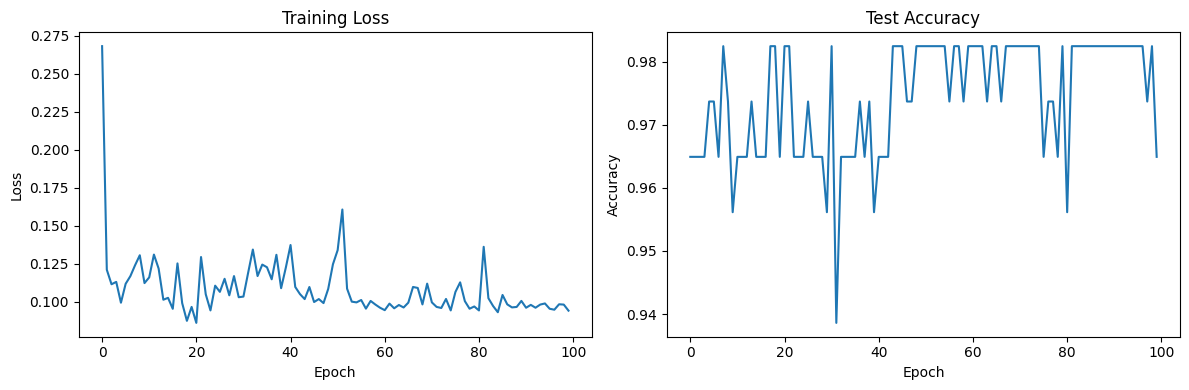


Explained variance ratio of PCA components:
[0.43326478 0.20783302 0.08531071 0.07572    0.05537629]
Total variance explained: 0.8575


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# 1. Load breast cancer dataset and select 25 features
data = load_breast_cancer()
X, y = data.data[:, :25], data.target

# 2. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Apply PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 5. Convert to PyTorch tensors and create DataLoader with batch size 1
train_dataset = TensorDataset(torch.FloatTensor(X_train_pca), torch.FloatTensor(y_train).reshape(-1, 1))
test_dataset = TensorDataset(torch.FloatTensor(X_test_pca), torch.FloatTensor(y_test).reshape(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 6. Define the neural network with exactly 23 parameters
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Layer 1: 5 params (5 weights, no bias)
        self.layer1_weight = nn.Parameter(torch.randn(5))  # 5 parameters
        
        # Layer 2: 6 params (5 weights + 1 bias)
        self.layer2 = nn.Linear(5, 1, bias=True)  # 5*1 + 1 = 6 params
        
        # Layer 3: Leaky ReLU (0 params)
        self.leaky_relu = nn.LeakyReLU(0.01)
        
        # Layer 4: 6 params (5 weights + 1 bias)
        self.layer4 = nn.Linear(1, 5, bias=True)  # 1*5 + 1 = 6 params
        
        # Layer 5: Leaky ReLU (0 params)
        
        # Layer 6: 6 params (5 weights + 1 bias)
        self.layer6 = nn.Linear(5, 1, bias=True)  # 5*1 + 1 = 6 params
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Layer 1: (1, 5) -> (1, 5)
        x = x * self.layer1_weight
        
        # Layer 2: (1, 5) -> (1, 1)
        x = self.layer2(x)
        
        # Layer 3: (1, 1) -> (1, 1)
        x = self.leaky_relu(x)
        
        # Layer 4: (1, 1) -> (1, 5)
        x = self.layer4(x)
        
        # Layer 5: (1, 5) -> (1, 5)
        x = self.leaky_relu(x)
        
        # Layer 6: (1, 5) -> (1, 1)
        x = self.layer6(x)
        x = self.sigmoid(x)
        
        return x

# 7. Training function
def train_model(model, train_loader, test_loader, epochs=100, lr=0.01):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)  # X_batch: (1, 5)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                predicted = (outputs >= 0.5).float()
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.4f}, Test Accuracy: {accuracy:.4f}')
    
    return train_losses, test_accuracies

# 8. Main execution
def main():
    model = NeuralNetwork()
    
    # Explicitly count parameters
    params = {
        'Layer 1': model.layer1_weight.numel(),  # 5
        'Layer 2': sum(p.numel() for p in model.layer2.parameters()),  # 6
        'Layer 3': 0,
        'Layer 4': sum(p.numel() for p in model.layer4.parameters()),  # 6
        'Layer 5': 0,
        'Layer 6': sum(p.numel() for p in model.layer6.parameters())   # 6
    }
    total_params = sum(params.values())
    
    print(f"Parameter counts: {params}")
    print(f"Total number of parameters: {total_params}")
    
    
    train_losses, test_accuracies = train_model(model, train_loader, test_loader)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    print("\nExplained variance ratio of PCA components:")
    print(pca.explained_variance_ratio_)
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

if __name__ == "__main__":
    main()